In [1]:
import theano
from theano import tensor as T
import lasagne
from lasagne.layers import *
from lasagne.nonlinearities import *
from lasagne.objectives import *
from lasagne.random import get_rng
from lasagne.updates import *
import numpy as np
import sys
sys.path.append("../../modules/")
import helper as hp

from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams

import matplotlib.pyplot as plt
%matplotlib inline

import os
import cPickle as pickle

from theano.tensor import TensorType

from theano.ifelse import ifelse

//anaconda/lib/python2.7/site-packages/Theano-0.8.0.dev0-py2.7.egg/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [192]:
"""
not working yet
"""
class SkipLayer(Layer):
    def __init__(self, incoming, wrapped_layer, p=0.5, **kwargs):
        super(SkipLayer, self).__init__(incoming, **kwargs)
        self._srng = RandomStreams(get_rng().randint(1, 2147462579))
        self.wrapped_layer = wrapped_layer
        self.incoming = incoming
        self.p = p
    def get_output_for(self, input, deterministic=False, **kwargs):
        # if deterministic, use the underlying layer
        if deterministic or self.p == 0:
            return self.wrapped_layer.get_output_for(input, deterministic=False, **kwargs)
        else:
            # if uniform(0,1) < p, skip the underlying layer
            u = np.random.normal(0, 1)
            if u < self.p:
                print "ignoring"
                return input
            else:
                return self.wrapped_layer.get_output_for(input, deterministic=False, **kwargs)

----

In [3]:
"""
rs = np.random.RandomState(1234)
rng = theano.tensor.shared_randomstreams.RandomStreams(rs.randint(999999))
shp = (10,8,26,26)
#new_shp = np.asarray([shp[0]]).reshape(shp.shape)

mask = rng.binomial( n=1, p=(0.5), size=(10,1,1,1) )
print mask.broadcastable
mask = T.addbroadcast(mask, *[x for x in range(1, len(shp))])
print mask.broadcastable
print (mask * T.ones((10,8,26,26))).eval()
"""

'\nrs = np.random.RandomState(1234)\nrng = theano.tensor.shared_randomstreams.RandomStreams(rs.randint(999999))\nshp = (10,8,26,26)\n#new_shp = np.asarray([shp[0]]).reshape(shp.shape)\n\nmask = rng.binomial( n=1, p=(0.5), size=(10,1,1,1) )\nprint mask.broadcastable\nmask = T.addbroadcast(mask, *[x for x in range(1, len(shp))])\nprint mask.broadcastable\nprint (mask * T.ones((10,8,26,26))).eval()\n'

In [3]:
class SkippableNonlinearityLayer(Layer):
    def __init__(self, incoming, nonlinearity=rectify, p=0.5, max_=10,
                 **kwargs):
        super(SkippableNonlinearityLayer, self).__init__(incoming, **kwargs)
        self.nonlinearity = (identity if nonlinearity is None
                             else nonlinearity)
        self._srng = RandomStreams(get_rng().randint(1, 2147462579))
        self.p = p
        self.max_ = max_

    def get_output_for(self, input, deterministic=False, **kwargs):
        if deterministic and self.p == 0.0:
            # apply the bernoulli expectation
            return self.p*input + (1-self.p)*self.nonlinearity(input)
        else:
            # if uniform(0,1) < p, then apply I(x), else g(x)
            # so the probability of applying a nonlinearity
            # is 1-p
            """
            return ifelse(
                T.lt(self._srng.uniform( (1,), 0, 1)[0], self.p),
                input,
                self.nonlinearity(input)
            )
            """
            #print input.ndim
            
            if input.ndim==4:
                mask = self._srng.binomial(n=1, p=(self.p), size=(input.shape[0],1,1,1),
                    dtype=input.dtype)
                mask = T.addbroadcast(mask, 1,2,3)
                return mask*input + (1-mask)*self.nonlinearity(input)
            elif input.ndim == 2:
                mask = self._srng.binomial(n=1, p=(self.p), size=(input.shape[0],1),
                    dtype=input.dtype)
                mask = T.addbroadcast(mask, 1)
                return mask*input + (1-mask)*self.nonlinearity(input) 
            
            #return input
            

In [4]:
shallow_net = [
    ("conv", 3, 16, 1),
    ("maxpool", 2),
    ("conv", 3, 32, 1),
    ("maxpool", 2),
    ("conv", 3, 64, 1),
    ("dense", 128)
]

In [5]:
deep_net = [
    ("conv", 3, 8, 1),
    ("conv", 3, 8, 1),
    ("conv", 3, 8, 1),
    
    ("conv", 3, 16, 1),
    ("conv", 3, 16, 1),
    ("conv", 3, 16, 1),
    ("conv", 3, 16, 1),
    ("conv", 3, 16, 1),
    ("conv", 3, 16, 1),
    
    ("conv", 3, 32, 1),
    ("conv", 3, 32, 1),
    ("conv", 3, 32, 1),
    ("conv", 3, 32, 1),
    
    ("dense", 128) 
]

In [50]:
def get_net(cfg, data, args={}):
    nonlinearity = args["nonlinearity"] if "nonlinearity" in args else linear
    l_in = InputLayer( (None, 1, 28, 28) )
    l_prev = l_in
    for line in cfg:
        if line[0] == "conv":
            #l_prev = Conv2DLayer(l_prev, filter_size=line[1], num_filters=line[2], nonlinearity=linear, stride=line[3])           
            l_prev = SkippableNonlinearityLayer(
                Conv2DLayer(l_prev, filter_size=line[1], num_filters=line[2], nonlinearity=linear, stride=line[3]),
                nonlinearity=nonlinearity,
                p=args["p"])
        elif line[0] == "maxpool":
            l_prev = MaxPool2DLayer(l_prev, pool_size=line[1])
        elif line[0] == "dense":
            l_prev = SkippableNonlinearityLayer( DenseLayer(l_prev, num_units=line[1], nonlinearity=linear),
                nonlinearity=nonlinearity, p=args["p"] )
        sys.stderr.write( str(l_prev.output_shape) + "\n" )
    l_out = DenseLayer(l_prev, num_units=10, nonlinearity=softmax)
    sys.stderr.write(str(count_params(l_out)) + "\n")
    # ----
    X = T.tensor4('X')
    y = T.ivector('y')
    idx = T.lscalar('idx')
    # ----
    net_out = get_output(l_out, X)
    net_out_det = get_output(l_out, X, deterministic=True)
    loss = categorical_crossentropy(net_out, y).mean()
    params = get_all_params(l_out, trainable=True)
    grads = total_norm_constraint( T.grad(loss, params), max_norm=10)
    updates = nesterov_momentum(grads, params, learning_rate=0.01, momentum=0.9)
    # index fns
    bs = args["batch_size"]
    X_train, y_train, X_valid, y_valid = data
    train_fn = theano.function(inputs=[idx], outputs=loss, updates=updates, 
        givens={
            X: X_train[idx*bs : (idx+1)*bs],
            y: y_train[idx*bs : (idx+1)*bs]
        }
    )
    loss_fn = theano.function(inputs=[], outputs=loss, 
        givens={
            X: X_valid,
            y: y_valid
        }
    )
    eval_fn = theano.function(inputs=[idx], outputs=net_out_det,
        givens={
            X:X_train[idx*bs : (idx+1)*bs]
        }
    )
    
    tmp_fn = theano.function([X], net_out)
    outs_with_nonlinearity = theano.function(
        [X], [ get_output(layer, X, deterministic=True) for layer in get_all_layers(l_out) 
              if isinstance(layer, SkippableNonlinearityLayer) ]
    )
    outs_without_nonlinearity = theano.function(
        [X], [ get_output(layer, X, deterministic=True) for layer in get_all_layers(l_out) 
              if isinstance(layer, Conv2DLayer) or isinstance(layer, DenseLayer) ]
    )
    return {
        "train_fn": train_fn,
        "eval_fn": eval_fn,
        "loss_fn": loss_fn,
        "outs_with_nonlinearity": outs_with_nonlinearity,
        "outs_without_nonlinearity": outs_without_nonlinearity,
        "l_out": l_out,
        "tmp_fn": tmp_fn
    }

In [70]:
train_data, valid_data, _ = hp.load_mnist("../../data/mnist.pkl.gz")
X_train, y_train = train_data
X_valid, y_valid = valid_data
X_train = theano.shared(np.asarray(X_train, dtype=theano.config.floatX), borrow=True)
y_train = theano.shared(np.asarray(y_train, dtype=theano.config.floatX), borrow=True)
X_valid = theano.shared(np.asarray(X_valid, dtype=theano.config.floatX), borrow=True)
y_valid = theano.shared(np.asarray(y_valid, dtype=theano.config.floatX), borrow=True)
y_train = T.cast(y_train, "int32")
y_valid = T.cast(y_valid, "int32")

In [37]:
X_valid.dtype

'float32'

In [22]:
"""
DON'T USE
"""
def iterate(X_train, y_train, batch_size):
    b = 0
    idxs = [x for x in range(0, X_train.shape[0])]
    while True:
        np.random.shuffle(idxs)
        if b*batch_size >= X_train.shape[0]:
            break
        X_batch = X_train[idxs][b*batch_size:(b+1)*batch_size]
        y_batch = y_train[idxs][b*batch_size:(b+1)*batch_size] 
        b += 1
        yield X_batch, y_batch

In [67]:
def train(X_train, y_train, X_valid, y_valid, 
          net_cfg, 
          num_epochs, 
          batch_size, 
          out_file=None,
          print_out=True,
          debug=False):
    # prepare the out_file
    f = None
    if out_file != None:
        f = open("%s.txt" % out_file, "wb")
        f.write("train_loss,valid_loss\n")
    if print_out:
        print "train_loss,valid_loss"
    # extract functions
    train_fn = net_cfg["train_fn"]
    loss_fn = net_cfg["loss_fn"]
    outs_with_nonlinearity = net_cfg["outs_with_nonlinearity"]
    # training
    train_losses = []
    n_batches = X_train.get_value().shape[0] // batch_size
    idxs = [x for x in range(0, n_batches)]
    if debug:
        sys.stderr.write("n_batches: %s\n" % n_batches)
        sys.stderr.write("idxs: %s\n" % idxs)
    for epoch in range(0, num_epochs):
        this_train_losses = []
        np.random.shuffle(idxs)
        for i in range(0, len(idxs)):
            loss_for_this_batch = train_fn( idxs[i] )
            this_train_losses.append( loss_for_this_batch )
        train_losses.append( np.mean(this_train_losses) )
        valid_loss = loss_fn()
        if f != None:
            f.write( "%f,%f\n" % (np.mean(this_train_losses), valid_loss) )
        if print_out:
            print "%f,%f" % (np.mean(this_train_losses), valid_loss)
        #print valid_loss
        #return train_losses
    if f != None:
        f.close()
        # ok, now save the model as a pkl
        l_out = net_cfg["l_out"]
        with open("%s.model" % out_file, "wb") as g:
            pickle.dump(get_all_param_values(l_out), g, pickle.HIGHEST_PROTOCOL)

If we train two networks: one with $p = 0$ and $p = 0.5$, we expect the latter to have activations that are not close to the saturation regime. This is because if $x$ is very big, $tanh(x)$ will be in the saturation regime, but when we compute $I(x) = x$, this will be massive, therefore significantly influencing the subsequent layers and forcing backprop to lower the magnitude of $x$.

In [64]:
tmp_net = get_net(
    shallow_net,
    (X_train, y_train, X_valid, y_valid),
    { "p":0.0, "nonlinearity": tanh, "batch_size": 10}
)

(None, 16, 26, 26)
(None, 16, 13, 13)
(None, 32, 11, 11)
(None, 32, 5, 5)
(None, 64, 3, 3)
(None, 128)
98442


Let's verify the implementation using a dummy example.

In [12]:
def test_this():
    l_in = InputLayer( (None, 5) )
    l_dense = DenseLayer(l_in, num_units=5, nonlinearity=linear, W=np.eye(5))
    l_id = SkippableNonlinearityLayer(l_dense, nonlinearity=sigmoid)
    X = T.fmatrix()
    out = get_output(l_id, X)
    return theano.function([X], out)
dummy_net_eval = test_this()

In [17]:
dummy_net_eval( np.ones((4, 5), dtype="float32") )

array([[ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ],
       [ 0.73105858,  0.73105858,  0.73105858,  0.73105858,  0.73105858]])

Let's try a "deep" net on a subset of MNIST, and see what the outputs look like.

In [43]:
skip_check = True

In [71]:
if skip_check or os.environ["HOSTNAME"] == "cuda4.rdgi.polymtl.ca":
    for p in [0.1, 0.2, 0.3, 0.4, 0.5]:
        for nonlinearity in [("sigmoid", sigmoid), ("tanh", tanh), ("relu", rectify)]:
            np.random.seed(0)
            args = {"p":p, "nonlinearity": nonlinearity[1], "batch_size": 128}
            id_net = get_net(deep_net, (X_train, y_train, X_valid, y_valid), args)
            train_losses_with_id = train(
                X_train, y_train, X_valid, y_valid,
                id_net,
                num_epochs=10,
                batch_size=args["batch_size"],
                out_file="output/p%f_%s" % (p, nonlinearity[0]),
                debug=False
            )

(None, 8, 26, 26)
(None, 8, 24, 24)
(None, 8, 22, 22)
(None, 16, 20, 20)
(None, 16, 18, 18)
(None, 16, 16, 16)
(None, 16, 14, 14)
(None, 16, 12, 12)
(None, 16, 10, 10)
(None, 32, 8, 8)
(None, 32, 6, 6)
(None, 32, 4, 4)
(None, 32, 2, 2)
(None, 128)
64202


KeyboardInterrupt: 

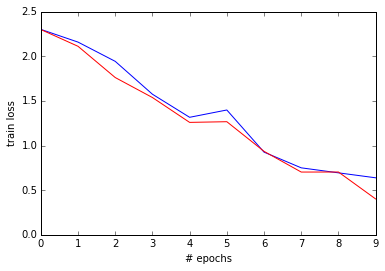

In [50]:
plt.plot(train_losses_without_id, "b-", train_losses_with_id, "r-")
plt.xlabel("# epochs")
plt.ylabel("train loss")

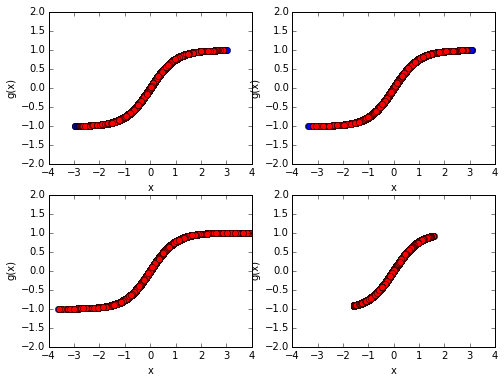

In [181]:
plt.figure(figsize=(8,6))
for i in range(0,4):
    plt.subplot(2,2,i)
    plt.xlim(-4, 4)
    plt.ylim(-2, 2)
    plt.plot(
        no_id_net["outs_without_nonlinearity"](X_train[0:100])[i].flatten(),
        no_id_net["outs_with_nonlinearity"](X_train[0:100])[i].flatten(),
        "bo",
        id_net["outs_without_nonlinearity"](X_train[0:100])[i].flatten(),
        id_net["outs_with_nonlinearity"](X_train[0:100])[i].flatten(),
        "ro",
    )
    plt.ylabel("g(x)")
    plt.xlabel("x")

In [49]:
%Rpush train_losses

In [51]:
train_losses_2 = \
    train(X_train, y_train, X_valid, y_valid, get_net({"p":0}), num_epochs=7, bs=32)

(None, 1, 28, 28)
(None, 16, 26, 26)
(None, 16, 26, 26)
(None, 16, 13, 13)
(None, 32, 11, 11)
(None, 32, 11, 11)
(None, 32, 5, 5)
(None, 64, 3, 3)
(None, 64, 3, 3)
(None, 10)
29066


In [52]:
%Rpush train_losses_2

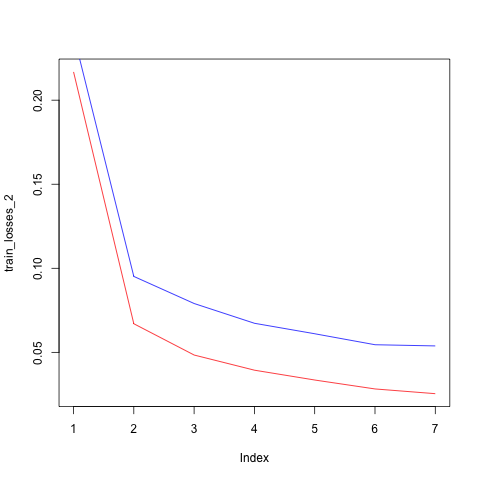

In [59]:
%%R
plot(train_losses_2, type="l", col="red")
lines(train_losses, col="blue")